In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os

import seaborn as sns

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
filepath_isotypes = '/networks/cavd/VDCs/Schief/Schief_856-G002/SkinReactions/data/Glycan_array_Scripps/processed_data/DRAFT_CAVD_G002_Glycan_Microarray_data_processed_2024-10-16.txt'
df_glycan_isotypes = pd.read_csv(filepath_isotypes, sep="\t")

/tmp/ipykernel_27893/4284450680.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_glycan_isotypes = pd.read_csv(filepath_isotypes, sep="\t")


In [6]:
usecols = ['sample_id',
           'isotype', 
           'ptid', 
           'study_week',
           'spot_name', 
           'glycan_m_number', 
           'background_subtraced_mean_signal']

df = df_glycan_isotypes[usecols]

In [7]:
df.sample_id = df.sample_id.astype(str)

In [8]:
cc = df[['sample_id','ptid','study_week']].drop_duplicates()

In [9]:
def centered_mean(x):
    if len(x) >= 6:
        return np.mean(np.sort(x)[1:-1])
    else:
        return np.mean(x)

df['centered_mean'] = df.groupby(['isotype','sample_id','glycan_m_number'])[['background_subtraced_mean_signal']].transform(centered_mean)
        
# df['normal_mean'] = df.groupby(['isotype','sample_id','glycan_m_number'])[['background_subtraced_mean_signal']].transform("mean")
# df['count_of_applicable'] = df.groupby(['isotype','sample_id','glycan_m_number'])[['background_subtraced_mean_signal']].transform(lambda x: len(x))
# df['centered_mean'] = df.groupby(['isotype','sample_id','glycan_m_number'])[['background_subtraced_mean_signal']].transform(lambda x: np.mean(np.sort(x)[1:-1]))
# df = df.drop(columns='background_subtraced_mean_signal').drop_duplicates()

df = df.drop(columns='background_subtraced_mean_signal').drop_duplicates()

df = df.reset_index(drop=True)

calc_responses = df.copy()

calc_responses['threshold'] = 100
calc_responses['response_flag'] = calc_responses.centered_mean > 100
calc_responses["count_of_responses"] = calc_responses.groupby(['isotype','study_week','glycan_m_number'])[['response_flag']].transform('sum')
calc_responses["prop_of_responses"] = calc_responses.groupby(['isotype','study_week','glycan_m_number'])[['response_flag']].transform(lambda x: x.sum()/len(x))

calc_responses["overall_response_rate"] = calc_responses.groupby(['isotype','glycan_m_number'])[['response_flag']].transform(lambda x: x.sum()/len(x))
calc_responses = calc_responses.sort_values(by='overall_response_rate', ascending=False)

In [10]:
# compare = pd.read_csv("/networks/vtn/lab/SDMC_labscience/operations/documents/templates/assay/template_testing/test_11_01_2024/" + "calc_responses.txt", sep="\t")

In [83]:
# calc_responses = calc_responses.reset_index(drop=True)

# calc_responses.sample_id = calc_responses.sample_id.astype(str)
# compare.sample_id = compare.sample_id.astype(str)

# calc_responses.ptid = calc_responses.ptid.astype(str)
# compare.ptid = compare.ptid.astype(str)

# for col in ind_cols:
#     diff = set(calc_responses[col]).symmetric_difference(compare[col])
#     print(f"{col}: {len(diff)}")

# for col in ['centered_mean','prop_of_responses','overall_response_rate']:
#     calc_responses[col] = np.round(calc_responses[col], 2)

# for col in ['centered_mean','prop_of_responses','overall_response_rate']:
#     compare[col] = np.round(compare[col], 2)

# calc_responses.compare(compare)

# boxplots

In [1]:
calc_responses = calc_responses.sort_values(by='overall_response_rate', ascending=False)
isotype = "IgG"

glycan_ordering = calc_responses.loc[calc_responses.isotype==isotype,['glycan_m_number','overall_response_rate']].drop_duplicates().glycan_m_number.tolist()

N = 4
M = 5
weeks = ["Wk 0", "Wk 8", "Wk 10"]

fig, ax = plt.subplots(nrows=N, ncols=M, figsize=(9,N*2.5), sharex=True, sharey=True)
for i in range(N):
    for j in range(M):
        k = i*M + j
        if k < len(glycan_ordering):
            glycan = glycan_ordering[k]
            g = calc_responses.loc[(calc_responses.glycan_m_number==glycan) & (calc_responses.isotype==isotype)]
            data = [list(g.loc[(g.study_week==w) & (g.centered_mean >= 100)].centered_mean) for w in weeks]
            ax[i,j].boxplot(data)
            ax[i,j].set_yscale("log")
            ax[i,j].set_ylim(ylim[isotype])
            ax[i,j].set_yticks(useticks[isotype])

            if len(glycan) > 20:
                usethis = str(glycan.replace(' ','\n'))
                ax[i,j].set_title(usethis, fontsize=10)
            else:
                ax[i,j].set_title(f"{glycan}", fontsize=10)
            if j==0:
                ax[i,j].set_ylabel("centered mean of\nbackground-normalized signal")

ax[N-1,M-1].set_xticks(ticks=np.arange(1,4), labels=weeks)
fig.tight_layout()
plt.show()


In [2]:
savedir = '/networks/vtn/lab/SDMC_labscience/operations/documents/templates/assay/template_testing/plots_11_04_2024/'

isotypes = ['IgE','IgM','IgG']
useticks = {}
useticks["IgG"] = [100, 1_000, 10_000, 15_000]
useticks["IgE"] = [100, 1_000, 1_700]
useticks["IgM"] = [100, 1_000]

ylim = {}
ylim['IgG'] = (100, 15_000)
ylim['IgE'] = (100, 1_700)
ylim['IgM'] = (100, 1_000)

for isotype in isotypes:
    glycan_ordering = calc_responses.loc[calc_responses.isotype==isotype,['glycan_m_number','overall_response_rate']].drop_duplicates().glycan_m_number.tolist()
    
    t = 0
    remaining_glycans = glycan_ordering
    while len(remaining_glycans)>0:
        t += 1
        N = 4
        M = 5
        weeks = ["Wk 0", "Wk 8", "Wk 10"]
        
        fig, ax = plt.subplots(nrows=N, ncols=M, figsize=(9,N*2.5), sharex=True, sharey=True)
        for i in range(N):
            for j in range(M):
                k = i*M + j
                if k < len(remaining_glycans):
                    glycan = remaining_glycans[k]
                    g = calc_responses.loc[(calc_responses.glycan_m_number==glycan) & (calc_responses.isotype==isotype)]
                    data = [list(g.loc[(g.study_week==w) & (g.centered_mean >= 100)].centered_mean) for w in weeks]
                    ax[i,j].boxplot(data)
                    ax[i,j].set_yscale("log")
                    ax[i,j].set_ylim(ylim[isotype])
                    ax[i,j].set_yticks(useticks[isotype])

                    if len(glycan) > 20:
                        usethis = str(glycan.replace(' ','\n'))
                        ax[i,j].set_title(usethis, fontsize=10)
                    else:
                        ax[i,j].set_title(f"{glycan}", fontsize=10)
                    if j==0:
                        ax[i,j].set_ylabel("centered mean of\nbackground-normalized signal")
        
        ax[N-1,M-1].set_xticks(ticks=np.arange(1,4), labels=weeks)
        fig.tight_layout()
        plt.savefig(savedir + f"{isotype}_boxplots{t}.png", dpi=320, format='png', transparent=False, bbox_inches='tight', pad_inches=0.3)
        remaining_glycans = remaining_glycans[20:]
    
    
    imgs = [f"{isotype}_boxplots{i}.png" for i in np.arange(1,6)]
    
    images = [
        Image.open(savedir + f)
        for f in imgs
    ]
    
    pdf_path = savedir + f"{isotype}_glycan_boxplots.pdf"
        
    images[0].save(
        pdf_path, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:]
    )

# histograms

In [87]:
response_stats = calc_responses[['isotype','study_week','glycan_m_number','count_of_responses','prop_of_responses']].drop_duplicates()

In [3]:
# plt.hist(response_stats.loc[(response_stats.isotype=="IgG") & (response_stats.study_week=="Wk 0")].count_of_responses)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharey=True)

weeks = ["Wk 0", "Wk 8", "Wk 10"]
isotypes = ["IgG", "IgE", "IgM"]
for i in range(3):
    for j in range(3):
        week = weeks[j]
        iso = isotypes[i]
        ax[i,j].hist(response_stats.loc[(response_stats.isotype==iso) & (response_stats.study_week==week)].count_of_responses, bins='sqrt')
        ax[i,j].set_title(f"{iso}, {week}")
        if j==0:
            ax[i,j].set_ylabel("Count of glycans")
        if i==2:
            ax[i,j].set_xlabel("Count of ppts responders ")

fig.tight_layout()
fig.suptitle('Histogram: count of ppts who are responders\nSignal threshold: 100', y=1.05, fontsize=14)
plt.show()

In [4]:
# plt.hist(response_stats.loc[(response_stats.isotype=="IgG") & (response_stats.study_week=="Wk 0")].count_of_responses)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharey=True)

weeks = ["Wk 0", "Wk 8", "Wk 10"]
isotypes = ["IgG", "IgE", "IgM"]
for i in range(3):
    for j in range(3):
        week = weeks[j]
        iso = isotypes[i]
        ax[i,j].hist(response_stats.loc[(response_stats.isotype==iso) & (response_stats.study_week==week)].prop_of_responses, bins='sqrt')
        ax[i,j].set_title(f"{iso}, {week}")
        if j==0:
            ax[i,j].set_ylabel("Count of glycans")
        if i==2:
            ax[i,j].set_xlabel("Prop of ppts responders ")



fig.tight_layout()
fig.suptitle('Histogram: prop of ppts who are responders\nSignal threshold: 100', y=1.05, fontsize=14)
plt.show()

In [3]:
## see cavd_glycan_concordance_10_22_2024 for concordance code

# Concordance

Would you make a few plots of the magnitudes of the responses relative to the estimated normal distribution based on the negative values.  It could be simply a boxplot of the magnitudes with a line showing the 3*SD cutoff.  Or maybe you can think of a better way.  Then put them all together in a 95 row by 3 column (glycan by time point) array in ordering the glycans by the response rate at week 0.  This would probably need to be split across a few pages to be able to see all of the results.
 
Another thing to look for is any evidence of a vaccine induced response.  IgG is surprising because the fraction of glycans with zero responses goes up over time.  That suggests to me that we might need to consider computing the threshold separately by glycan and week.  I’m not quite sure how best to address the question of vaccine induced responses.  The histograms you generated suggest that there aren’t any.  You could look at concordance of the response calls across time (say week 0 vs. week 8 and week 0 vs. week 10) and concordance in magnitudes (same time point comparisons).

---------------
3)	Some measure of concordance between weeks 0 and 8 and weeks 0 and 10.  For example, tables of response call concordance and/or pairwise plots would help us understand if responses are maintained over time or if they are changing.  Line plots might be another option.  

In [11]:
from matplotlib.ticker import ScalarFormatter

In [12]:
calc_responses = calc_responses.sort_values(by='overall_response_rate', ascending=False)

In [13]:
import scipy.stats as stats

In [15]:
calc_responses[['sample_id','isotype','ptid','study_week','glycan_m_number']].drop_duplicates().shape

(42750, 5)

In [16]:
byptid = pd.pivot_table(calc_responses, index=['isotype','ptid','glycan_m_number'], columns='study_week', values='centered_mean')

In [17]:
byptid = byptid[['Wk 0', 'Wk 8', 'Wk 10']].reset_index()

In [106]:
def equalityline(x, y, **kwargs):
    plt.plot([0, max(x)], [0, max(y)], linewidth=0.5, color='black')

In [5]:
for isotype in ['IgG','IgE','IgM']:
    igg_pairplot = sns.pairplot(byptid.loc[(byptid.isotype==isotype),['Wk 0','Wk 8','Wk 10']])
    igg_pairplot.map_offdiag(equalityline)
    igg_pairplot.fig.suptitle(f"{isotype}; ptid/glycan-level mean signal comparison", y=1.1)
    igg_pairplot.savefig(savedir + f"{isotype}_ptid_level_mean_signalcomparison.png")


imgs = [f"{isotype}_ptid_level_mean_signalcomparison.png" for isotype in ['IgG','IgE','IgM']]

images = [
    Image.open(savedir + f)
    for f in imgs
]

pdf_path = savedir + "mean_signal_pairplots.pdf"
    
images[0].save(
    pdf_path, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:]
)

In [112]:
byglycan = pd.pivot_table(calc_responses, index=['isotype','glycan_m_number'], columns='study_week', values='prop_of_responses')

In [115]:
byglycan = byglycan[['Wk 0','Wk 8', 'Wk 10']].reset_index()

In [6]:
for isotype in ['IgG','IgE','IgM']:
    igg_pairplot = sns.pairplot(byglycan.loc[(byglycan.isotype==isotype),['Wk 0','Wk 8','Wk 10']])
    igg_pairplot.map_offdiag(equalityline)
    igg_pairplot.fig.suptitle(f"{isotype}; glycan-level response rate comparison", y=1.1)
    igg_pairplot.savefig(savedir + f"{isotype}_glycan_level_response_rate_pairplot.png")


imgs = [f"{isotype}_glycan_level_response_rate_pairplot.png" for isotype in ['IgG','IgE','IgM']]

images = [
    Image.open(savedir + f)
    for f in imgs
]

pdf_path = savedir + "response_rate_pairplots.pdf"
    
images[0].save(
    pdf_path, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:]
)

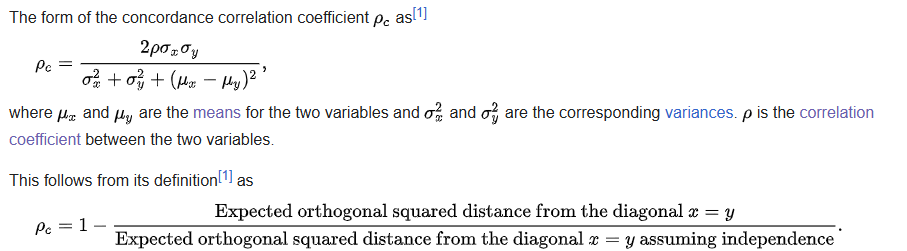

In [21]:
def concord(x,y):
    rho = stats.pearsonr(x,y).statistic
    sigma_x = np.var(x)
    sigma_y = np.var(y)
    mu_x = np.mean(x)
    mu_y = np.mean(y)

    return 2*rho*sigma_x*sigma_y/(sigma_x**2 + sigma_y**2 + (mu_x - mu_y)**2)


def get_concord(isotype, glycan, wk):
    g = byptid.loc[(byptid.isotype==isotype) & (byptid.glycan_m_number==glycan) & (byptid['Wk 0'].notna()) & (byptid[wk].notna())]
    x = g['Wk 0']
    y = g[wk]
    return concord(x,y)

In [22]:
concordance_table = df[['isotype','spot_name','glycan_m_number']].drop_duplicates()

In [23]:
concordance_table["Wk 0/Wk 8"] = concordance_table.apply(lambda x: get_concord(x.isotype, x.glycan_m_number, 'Wk 8'), axis=1)
concordance_table["Wk 0/Wk 10"] = concordance_table.apply(lambda x: get_concord(x.isotype, x.glycan_m_number, 'Wk 10'), axis=1)

In [26]:
savedir = '/networks/vtn/lab/SDMC_labscience/operations/documents/templates/assay/template_testing/plots_11_04_2024/'

In [27]:
concordance_table.to_csv(savedir + "concordance_table.csv", index=False)

In [174]:
compare = pd.read_csv("/networks/vtn/lab/SDMC_labscience/operations/documents/templates/assay/template_testing/plots_10_22_2024_concordance/concordance_table.csv")

In [175]:
ct = concordance_table.drop(columns='spot_name')

In [178]:
ct = ct.sort_values(by=['isotype','glycan_m_number'])
compare = compare.sort_values(by=['isotype','glycan_m_number'])

compare = compare.reset_index(drop=True)
ct = ct.reset_index(drop=True)

In [179]:
compare = compare[ct.columns]

In [181]:
w8 = ct.compare(compare)['Wk 0/Wk 8']